In [1]:
!pip install transformers
!pip install gdown

     |████████████████████████████████| 1.3MB 9.6MB/s 
     |████████████████████████████████| 890kB 47.2MB/s 
     |████████████████████████████████| 2.9MB 50.2MB/s 
     |████████████████████████████████| 1.1MB 49.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=401483f34fc7c935b3f3d61d47f5d65684f6379ff0f26d25ee7667fd68e4d43e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [3]:
!gdown https://drive.google.com/uc?id=1YGJ708knQO6O89yA379NqmITLQsVvuf6
!gdown https://drive.google.com/uc?id=1gtAI6jQt0dhD10TtI53D8ugUWx96vAJS

Downloading...
From: https://drive.google.com/uc?id=1YGJ708knQO6O89yA379NqmITLQsVvuf6
To: /content/train.csv
29.1MB [00:00, 136MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1gtAI6jQt0dhD10TtI53D8ugUWx96vAJS
To: /content/test.csv
100% 1.83M/1.83M [00:00<00:00, 122MB/s]


In [4]:
import pandas as pd
df_train = pd.read_csv(r"train.csv")
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print(df_train["Label"].value_counts())
print("\n")
df_test = pd.read_csv(r"test.csv")
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))
print(df_test["Label"].value_counts())

Number of training sentences: 120,000

4    30000
3    30000
2    30000
1    30000
Name: Label, dtype: int64


Number of test sentences: 7,600

3    1900
2    1900
1    1900
4    1900
Name: Label, dtype: int64


**Classes:**

1:'World News'

2:'Sports News'

3:'Business News'

4:'Science-Technology News'

Training model with 120K takes a lot of time, even with GPU. For this workshop, we will move on with 10K training data and 2K test data.

In [5]:
df_train=df_train.groupby('Label').apply(lambda x: x.sample(frac=1/12,random_state=1)).reset_index(drop=True)
df_train["Label"].value_counts()

4    2500
3    2500
2    2500
1    2500
Name: Label, dtype: int64

In [6]:
df_train.sample(5)

,Label,Title,Description
6971,3,"Stocks Rise; Sprint, Nextel Deal Helps",NEW YORK (Reuters) - U.S. stocks rose on Wedn...
9150,4,Administration Shifts On Global Warming,A Bush administration report suggests that evi...
7360,3,Flextronics Has Profit; Stock Lower,SAN FRANCISCO (Reuters) - Flextronics Interna...
3982,2,"BCS shockers: Texas in Fiesta, Pitt to Rose","As expected, Auburn is the odd team out of the..."
1089,1,US mulls new Darfur resolution,The United States said on Friday it is prepari...


In [7]:
df_test=df_test.groupby('Label').apply(lambda x: x.sample(frac=20/76,random_state=1)).reset_index(drop=True)
df_test["Label"].value_counts()

4    500
3    500
2    500
1    500
Name: Label, dtype: int64

In [8]:
df_test.sample(5)

,Label,Title,Description
1319,3,NASD Warns of Risky Home-Equity Investing,WASHINGTON (Reuters) - Too many house-rich Am...
1470,3,Campbell 9 Pct. Profit #39;Hmmm Hmmm Good #39;,"Campbell Soup Co. (CPB.N: Quote, Profile, Rese..."
409,1,Arafat Meets With Gaza Critic,A former Palestinian security minister who cou...
862,2,Lehman relishes chance to halt US slide,AFTER being named as the 2006 US Ryder Cup tea...
721,2,Australian Bookies Gutted After Betting Splurge,AUSTRALIA - As reported by the Sydney Morning ...


We will feed model with both title and description, rather than choosing only one of them. Therefore, these two text data will be merged.

In [9]:
df_train['Text'] = df_train['Title'] + ' ' + df_train['Description']
df_test['Text'] = df_test['Title'] + ' ' + df_test['Description']

df_train = df_train.drop(columns=['Title', 'Description'])
df_test = df_test.drop(columns=['Title', 'Description'])


## TEXT PREPROCESSING

For Transformers library, labels should begin from 0 to n-1.

In [10]:
df_train["Label"]=df_train["Label"].apply(lambda x: x-1)
df_test["Label"]=df_test["Label"].apply(lambda x: x-1)

In [11]:
df_test["Label"].unique()

array([0, 1, 2, 3])

In [12]:
df_train.Text[0]

'Haitians Pray for 1,500 Killed by Jeanne (AP) AP - In a cathedral ankle-deep in mud and overturned pews, Haitians prayed for 1,500 killed by Tropical Storm Jeanne and gave thanks for their lives  #151; though most lost homes and belongings  #151; while the United Nations rushed in hundreds more peacekeepers to stem looting by gangsters and ordinary citizens of the ravaged city of Gonaives.'

#### Stemming, lemmatization and the removal process of "stopwords", "punctuations" or "numerical values" are not required, since subword tokenizers and Transformer networks can deal with these.

In [14]:
import re
def preprocess(text):
  text=text.lower()
  
  text=text.replace("\n"," ")
  #removing URL
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)

  #Replace &amp, &lt, &gt with &,<,> respectively
  text=text.replace(r'&amp;?',r'and')
  text=text.replace(r'&lt;',r'<')
  text=text.replace(r'&gt;',r'>')

  #remove hashtags
  text=re.sub(r"#[A-Za-z0-9]+","",text)   
  #remove \
  text=re.sub(r"\\ "," ",text)
  #remove excess whitespace
  text= ' '.join(text.split())
  return text

df_train["Text"]=df_train["Text"].apply(preprocess)
df_test["Text"]=df_test["Text"].apply(preprocess)

In [15]:
df_train.Text[0]

'haitians pray for 1,500 killed by jeanne (ap) ap - in a cathedral ankle-deep in mud and overturned pews, haitians prayed for 1,500 killed by tropical storm jeanne and gave thanks for their lives ; though most lost homes and belongings ; while the united nations rushed in hundreds more peacekeepers to stem looting by gangsters and ordinary citizens of the ravaged city of gonaives.'

##### **BEFORE PREPROCESSING:**

> Haitians Pray for 1,500 Killed by Jeanne (AP) AP - In a cathedral ankle-deep in mud and overturned pews, Haitians prayed for 1,500 killed by Tropical Storm Jeanne and gave thanks for their lives  #151; though most lost homes and belongings  #151; while the United Nations rushed in hundreds more peacekeepers to stem looting by gangsters and ordinary citizens of the ravaged city of Gonaives.

##### **AFTER PREPROCESSING:**

> haitians pray for 1,500 killed by jeanne (ap) ap - in a cathedral ankle-deep in mud and overturned pews, haitians prayed for 1,500 killed by tropical storm jeanne and gave thanks for their lives ; though most lost homes and belongings ; while the united nations rushed in hundreds more peacekeepers to stem looting by gangsters and ordinary citizens of the ravaged city of gonaives.



# WordClouds

**WORD CLOUD FOR WORLD ARTICLES** 

(-0.5, 1199.5, 799.5, -0.5)

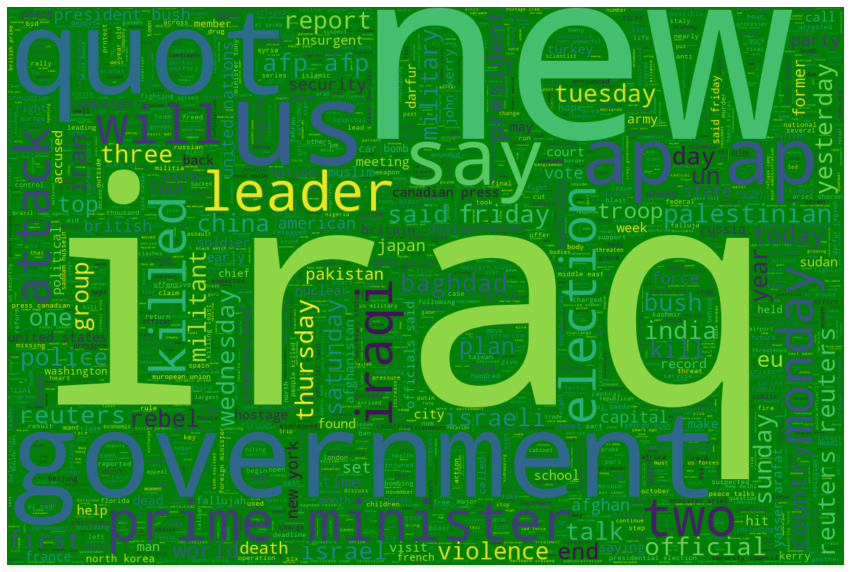

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

world = df_train.Text[df_train.Label[df_train.Label==0].index]
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800,background_color="green").generate(" ".join(world))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")

**WORD CLOUD FOR SPORTS ARTICLES** 

(-0.5, 1199.5, 799.5, -0.5)

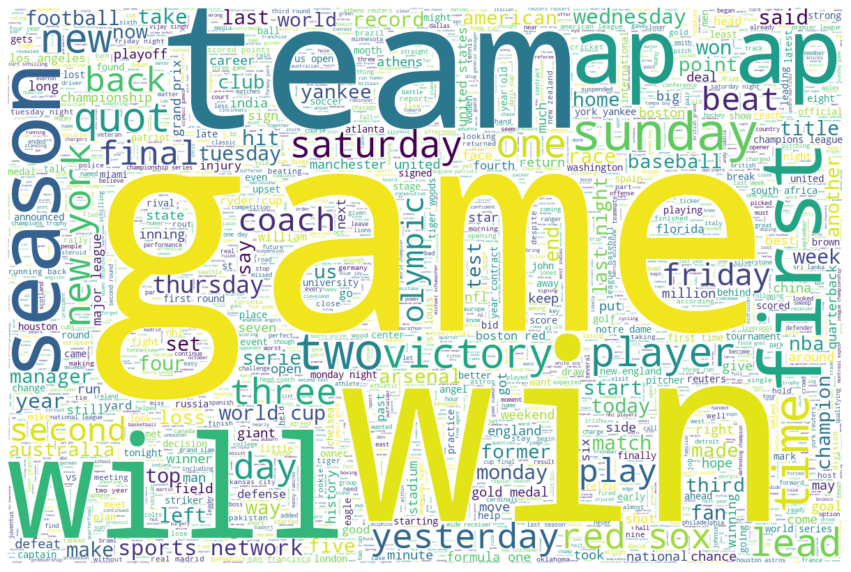

In [17]:
sports = df_train.Text[df_train.Label[df_train.Label==1].index]
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800,background_color="white").generate(" ".join(sports))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")

**WORD CLOUD FOR BUSINESS ARTICLES** 

(-0.5, 1199.5, 799.5, -0.5)

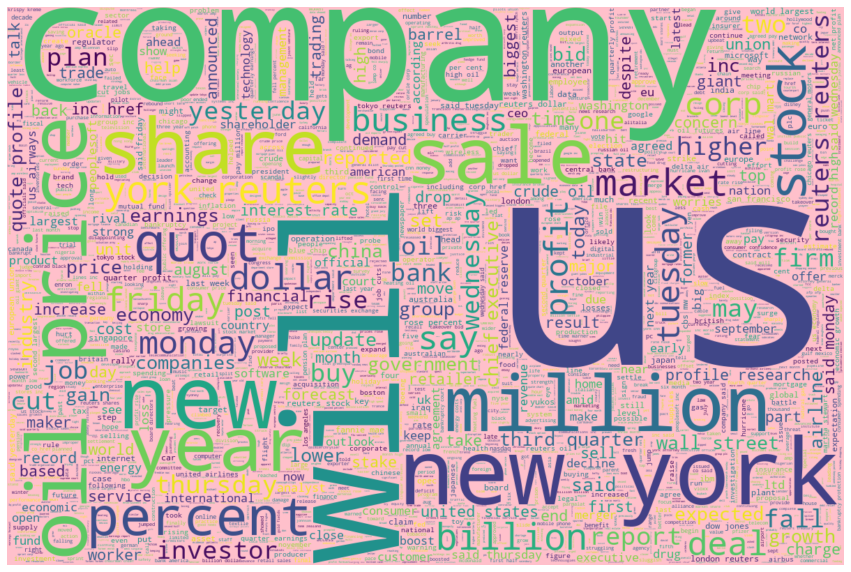

In [18]:
bus = df_train.Text[df_train.Label[df_train.Label==2].index]
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800,background_color="pink").generate(" ".join(bus))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")

**WORD CLOUD FOR SCI-TECH ARTICLES** 

(-0.5, 1199.5, 799.5, -0.5)

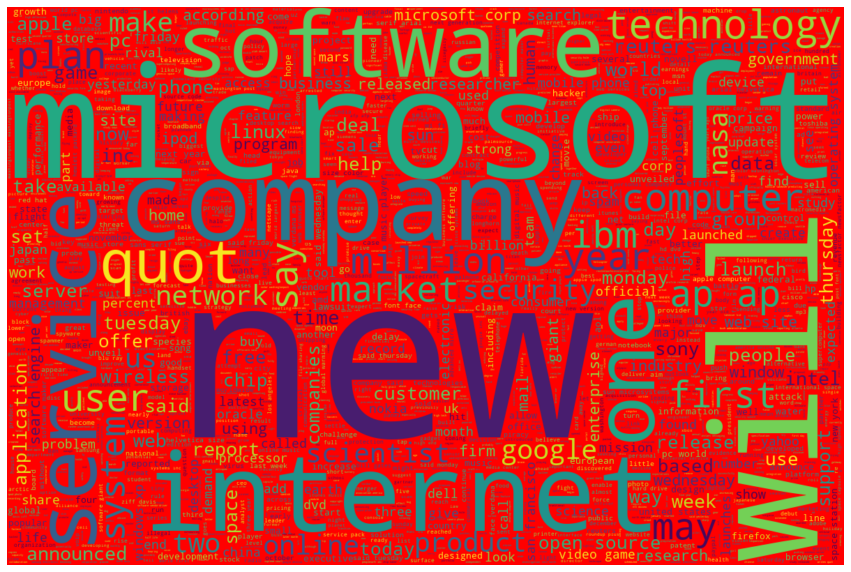

In [19]:
sci = df_train.Text[df_train.Label[df_train.Label==3].index]
plt.figure(figsize = (15,20)) ;
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800,background_color="red").generate(" ".join(sci))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")

# MODELLING

In [20]:
texts = df_train.Text.values
labels = df_train.Label.values

In [21]:
#BERT MODEL
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, AdamW
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 4)

model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
#to show length of embedding will be helpful to determine maximum length of comments and padding threshold
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

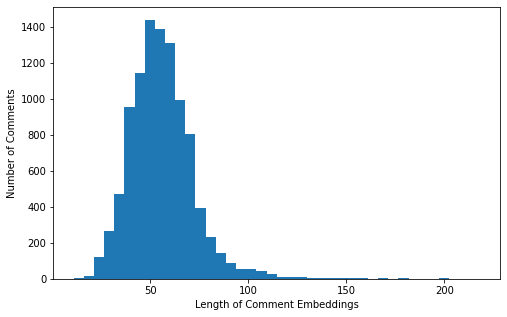

In [25]:
plot_sentence_embeddings_length(texts, tokenizer)

In [26]:
#128 length
indices=tokenizer.batch_encode_plus(texts,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]
print(input_ids[0])
print(attention_masks[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[101, 5871, 17030, 5443, 13805, 1111, 122, 117, 2260, 1841, 1118, 179, 7766, 1673, 113, 170, 1643, 114, 170, 1643, 118, 1107, 170, 8846, 10845, 118, 1996, 1107, 9052, 1105, 18252, 185, 17540, 117, 5871, 17030, 5443, 14913, 1111, 122, 117, 2260, 1841, 1118, 5065, 4162, 179, 7766, 1673, 1105, 1522, 5438, 1111, 1147, 2491, 132, 1463, 1211, 1575, 4481, 1105, 21924, 132, 1229, 1103, 10280, 6015, 6169, 1107, 5229, 1167, 3519, 26888, 1106, 8175, 25338, 13460, 1118, 27101, 1116, 1105, 6655, 4037, 1104, 1103, 187, 15677, 3660, 1331, 1104, 1301, 26727, 5710, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
from sklearn.model_selection import train_test_split


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [28]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [30]:
optimizer = AdamW(model.parameters(),lr = 5e-5, eps = 1e-8) #authors recommend 5e-5
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [31]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
start_time=time.time()
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    preds=[]
    true=[]

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        preds.append(logits)
        true.append(label_ids)
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Whole Training took: {:}".format(format_time(time.time()-start_time)))
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    50  of    250.    Elapsed: 0:00:11.
  Batch   100  of    250.    Elapsed: 0:00:23.
  Batch   150  of    250.    Elapsed: 0:00:34.
  Batch   200  of    250.    Elapsed: 0:00:45.

  Average training loss: 0.42
  Training epoch took: 0:00:56

Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    50  of    250.    Elapsed: 0:00:11.
  Batch   100  of    250.    Elapsed: 0:00:22.
  Batch   150  of    250.    Elapsed: 0:00:34.
  Batch   200  of    250.    Elapsed: 0:00:45.

  Average training loss: 0.20
  Training epoch took: 0:00:56

Running Validation...
  Accuracy: 0.92
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    50  of    250.    Elapsed: 0:00:11.
  Batch   100  of    250.    Elapsed: 0:00:22.
  Batch   150  of    250.    Elapsed: 0:00:34.
  Batch   200  of    250.    Elapsed: 0:00:45.

  Average training loss: 0.10
  Training epoch t

#TESTING THE MODEL

In [34]:
texts1 = df_test.Text.values
labels1 = df_test.Label.values

indices=tokenizer.batch_encode_plus(texts1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices["input_ids"]
attention_masks1=indices["attention_mask"]

# Convert to tensors.
prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)
prediction_labels1 = torch.tensor(labels1)

# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1, prediction_labels1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [35]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1, b_labels1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  label_ids1 = b_labels1.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits1)
  true_labels.append(label_ids1)

print('TEST PROCESS COMPLETED.')

Predicting labels for 2,000 test sentences...
TEST PROCESS COMPLETED.


In [36]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [37]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("Accuracy of BERT is:",accuracy_score(flat_true_labels, flat_predictions))
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

Accuracy of BERT is: 0.9075
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       500
           1       0.96      0.98      0.97       500
           2       0.88      0.86      0.87       500
           3       0.88      0.87      0.88       500

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



<Figure size 432x288 with 0 Axes>

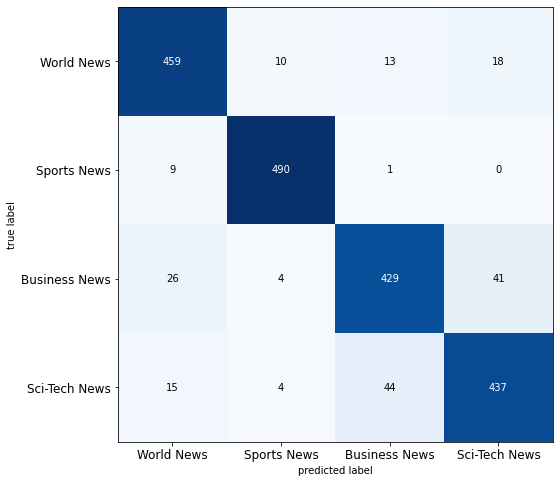

In [38]:
cm  = confusion_matrix(flat_true_labels, flat_predictions)
labels = ['World News', 'Sports News', 'Business News', 'Sci-Tech News']
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(8,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

# Test model with arbitrary data

In [39]:
def get_prediction(news):
  news=preprocess(news)
  news=[news]
  indices=tokenizer.batch_encode_plus(news,max_length=128,add_special_tokens=True, return_attention_mask=True,truncation=True)
  inputs = torch.tensor(indices["input_ids"], dtype=torch.long).to(device)
  masks = torch.tensor(indices["attention_mask"], dtype=torch.long).to(device)
  with torch.no_grad():
    output = model(inputs, token_type_ids=None,attention_mask=masks)
  logits = output[0]
  logits=logits.detach().cpu().numpy()
  if np.argmax(logits,axis=1)[0]==0:
      topic="TOPIC FOR THIS NEWS IS WORLD"
  elif np.argmax(logits,axis=1)[0]==1:
      topic="TOPIC FOR THIS NEWS IS SPORTS"
  elif np.argmax(logits,axis=1)[0]==2:
      topic="TOPIC FOR THIS NEWS IS BUSINESS"
  else:
      topic="TOPIC FOR THIS NEWS IS SCIENCE AND TECHNOLOGY"
  return news, topic

World News Source: https://edition.cnn.com/style/article/saqqara-sarcophagi-egypt/index.html

In [40]:
news="Archaeologists unearth 'huge number' of sealed Egyptian sarcophagi Archaeologists in Egypt have discovered another large cache of unopened sarcophagi in Saqqara, adding to the trove of almost 60 coffins recently recovered from the ancient necropolis. Although full details are yet to be announced, authorities said in a statement that a huge number of wooden sarcophagi had been unearthed. The country's Tourism and Antiquities Minister Khaled El-Enany said on Instagram that the find amounted to dozens of coffins, adding that they have been sealed since ancient times. The collection of sarcophagi, stored in three newly discovered burial shafts, is believed to date back more than 2,500 years. Colored and gilded statues were also found in the tombs, a government press release said. On Monday, El-Enany and Egyptian Prime Minister Mostafa Madbouly visited the site alongside secretary general of the Supreme Council of Antiquities, Mustafa Waziri. Photos released by the Ministry of Tourism and Antiquities show the trio being lowered into a shaft before inspecting painted coffins and a variety of other objects."

In [41]:
_ ,topic=get_prediction(news)
print(topic)

TOPIC FOR THIS NEWS IS WORLD


Sport News Source: https://edition.cnn.com/2020/10/19/football/champions-league-group-stage-preview-spt-intl/index.html

In [42]:
news2="Champions League: Can Bayern Munich become just second team in history to retain the trophy? Only one team in Champions League history has previously won back-to-back titles. Real Madrid's all-conquering team, led by Zinedine Zidane, won club football's biggest prize for an unprecedented three consecutive years between 2016 and 2018 -- now Bayern Munich has a realistic chance of doing the same. Few could argue that the perennial German champion was not the best team in Europe last season and a deserving Champions League winner. Hansi Flick's side returned from the coronavirus-enforced break in unstoppable form, winning every remaining game of the season. The most eye-catching victory in the record-breaking 23-game winning streak -- which began against Cologne back in February and ended with defeat to Hoffenheim at the end of September -- was the 8-2 humiliation of Barcelona in the Champions League quarterfinals. It's also been estimated that Bayern could earn over $150 million for winning last season's tournament. Perhaps most concerningly for Bayern's European rivals is that the Bavarian club has arguably only gotten stronger in the off-season. Despite losing midfield maestro Thiago to Liverpool and Philippe Coutinho returning to Barcelona, Bayern has bolstered its ranks with the additions of Leroy Sane from Manchester City and highly-rated Spanish youngster Marc Roca, as well as the return of winger Douglas Costa."

In [43]:
_ ,topic=get_prediction(news2)
print(topic)

TOPIC FOR THIS NEWS IS SPORTS


Tech News Source: https://edition.cnn.com/2020/10/19/tech/iphone-12-mini-battery/index.html

In [44]:
news3="The iPhone 12 Mini's big drawback: A tiny battery Apple claimed there was no difference between the iPhone 12 and the iPhone 12 Mini except for their size and their price. That's not technically true — because the iPhone 12 Mini is so much smaller, it has a significantly tinier battery. Apple says the iPhone 12 Mini gets two hours less battery life than its larger sibling — 15 hours of video playback on the iPhone 12 Mini compared with 17 hours on the iPhone 12. That's still impressive, especially considering some of the iPhone's larger rivals have substantially larger batteries and don't get nearly as much life out of them. Apple has always worked some magic with battery life by making its software and chips work seamlessly together. But lower battery life remains tradeoff of the iPhone 12 Mini. Sure, you're getting the same screen, camera, chip, software and other features for $100 less, in a 5.4-inch package. But when your buddy with the bigger phone is at 20% and you're at 5%, you might be rethinking whether the smaller phone was the right choice."

In [45]:
_ ,topic=get_prediction(news3)
print(topic)

TOPIC FOR THIS NEWS IS SCIENCE AND TECHNOLOGY


Business News Source: https://edition.cnn.com/2020/10/19/investing/biden-housing-market-suburbs/index.html

In [46]:
news4="Biden could benefit from the exodus to suburbs The US housing market has remained red-hot this year during the pandemic as some flee expensive coastal cities for the suburbs. And experts say there could be election consequences. These urban-dwellers likely aren't trying to make a political statement: They're simply looking for more space and cheaper prices. But if more Democrat-leaning voters are suddenly moving to Republican enclaves, that could change the political landscape. 'We don't know the exact political leanings of the people who are leaving, but we know people are leaving blue areas for red areas because expensive coastal cities dont have as much affordable housing,' said Redfin chief economist Daryl Fairweather in an interview with CNN Business. According to research published this month from online real estate brokerage Redfin (RDFN), lower housing costs in red states have driven the trend: The average home price in counties that have tended to vote more for Democrats was $346,000 in August. Houses in red counties had an average price of $209,000. "

In [47]:
_ ,topic=get_prediction(news4)
print(topic)

TOPIC FOR THIS NEWS IS BUSINESS


You can follow us on Github, this notebook will be shared in Principai account after the workshop :)

# ÖZCAN GÜNDEŞ